In [28]:
using System.Threading;
using System.Diagnostics;
using Microsoft.DotNet.Interactive.Formatting;
#r "nuget:ScottPlot, 5.0.36"
#!csharp
#r "nuget: xunit, 2.8.1"
using Xunit;

class DefiniteIntegral
{
    public static double Solve(double a, double b, Func<double, double> function, double step, int threadsnumber)
    {
        double answ = 0;
        double[] split = new double[threadsnumber+1];
        double splitvar = (b - a) / threadsnumber;
        split[0] = a;
        for (int i = 1; i < threadsnumber + 1; i++)
        {
            split[i] = a + i * splitvar;
        }
        Thread[] thr = new Thread[threadsnumber];
        double[] splitres = new double[threadsnumber];
        for (int i = 0; i < threadsnumber; i++)
        {
            thr[i] = new Thread(() =>
            {
                int numb = Convert.ToInt32((split[i + 1] - split[i]) / step);
                double step1 = (split[i+1] - split[i]) / numb;
                double res = 0;

                for (int k = 0; k < numb; k++)
                {
                    res += Math.Round(function(split[i] + step * k),3);
                }
                res *= step1;
                splitres[i] = res;
            });
            thr[i].Start();
            thr[i].Join();
        }    
        foreach (var v in splitres)
            answ += v;

        return answ;
    }

    public static double SolveOneThr(double a, double b, Func<double, double> function,double dx)
    {
        int numb = Convert.ToInt32((b - a) / dx);
        double step = (b - a) / numb;
        double res = 0;

        for (int i = 0; i < numb; i++)
        {
            res += function(a + dx * i);
        }
        res *= step;
        return res;
    }
}

Installed Packages ScottPlot, 5.0.36 xunit, 2.8.1

In [ ]:
var X =(double x) => x;
var answ = DefiniteIntegral.Solve(-1, 1, X, 1e-4, 2);
Console.WriteLine(answ);
Assert.Equal(0, DefiniteIntegral.Solve(-1, 1, X, 1e-4, 2), 1e-4);

In [74]:
var SIN =(double x) => Math.Sin(x);
double step = 1e-1;
string optstep; bool find = false;
var answ = DefiniteIntegral.Solve(-100, 100, SIN, step, 4);
Console.WriteLine($"При шаге 1e-1 вычисленное значение = {answ}");
for(int i=2; i<7;i++)
{
    string step1 = "1e-"+Convert.ToString(i);
    step = Convert.ToDouble(step1);
    answ = DefiniteIntegral.Solve(-100, 100, SIN, step, 4);
    Console.WriteLine($"При шаге 1e-{i} вычисленное значение = {answ}");
    if(answ*10000 < 1 && find == false) {optstep = Convert.ToString($"1e-{i}"); find = true;}
}

При шаге 1e-1 вычисленное значение = 0.05060000000000048
При шаге 1e-2 вычисленное значение = 0.005059999999999343
При шаге 1e-3 вычисленное значение = 0.0005059999999993819
При шаге 1e-4 вычисленное значение = 5.060000000220444E-05
При шаге 1e-5 вычисленное значение = 5.059999995352116E-06
При шаге 1e-6 вычисленное значение = 5.060000118628505E-07


Лучшее время выполнения = 76 мс достигается при 3 количестве потоков



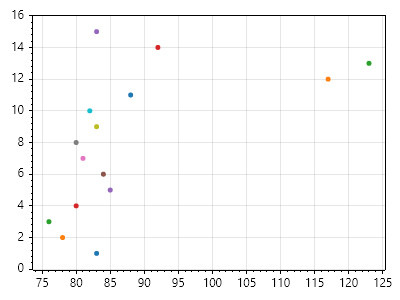

In [41]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);
ScottPlot.Plot plot = new();

int time = int.MaxValue, nthr = 1;
Stopwatch timer = new Stopwatch();

for(int threadsnumber = 1; threadsnumber <= 15; threadsnumber++)
{
    timer.Restart();
    DefiniteIntegral.Solve(-100,100,SIN,1e-4,threadsnumber);
    timer.Stop();
    if(time > timer.ElapsedMilliseconds)
    {
        nthr = threadsnumber;
        time = Convert.ToInt32(timer.ElapsedMilliseconds);
    }
    plot.Add.Scatter(timer.ElapsedMilliseconds, threadsnumber);
}

Console.WriteLine($"Лучшее время выполнения = {time} мс достигается при {nthr} количестве потоков");
plot

In [44]:
timer.Restart();
DefiniteIntegral.SolveOneThr(-100,100,SIN,1e-4);
timer.Stop();
var othr = timer.ElapsedMilliseconds;
Console.WriteLine($"Время работы в однопоточном режиме = {othr} мс");

Время работы в однопоточном режиме = 140 мс


In [76]:
var procent = Convert.ToDouble(othr)/Convert.ToDouble(time);
procent = Convert.ToInt32((procent - 1)*100);
Dictionary<string,string> Summary = new Dictionary<string,string>()
{
    {$"Оптимальный размер шага = ", $"{optstep};"},
    {$"Оптимальное количество потоков = ", $"{nthr};"},
    {$"Cкорость многопоточной версии = {time} мс, скорость однопоточной версии = {othr} мс, ", $"скорость многопоточной версии выше на {procent} %"},
}; 

foreach(var v in Summary)
{
    Console.WriteLine(v.Key+v.Value);
}

Оптимальный размер шага = 1e-4;
Оптимальное количество потоков = 3;
Cкорость многопоточной версии = 76 мс, скорость однопоточной версии = 140 мс, скорость многопоточной версии выше на 84 %
